## **Instalando e importando bibliotecas**

### **Instalando bibliotecas e clone de repositórios github**

In [ ]:
!pip install hydrobr
#!pip install ipywidgets #para criar os widgets
!pip install statsmodels
!pip install leafmap[raster] geopandas
!pip install earthengine-api
!pip install localtileserver
!pip install large-image[all]
#!git clone git://github.com/statsmodels/statsmodels.git
!git clone https://github.com/nevertonscariot/Bacia_Uruguai.git # geração de um clone dos programas necessarios feitos pelo GESPLA
!git clone https://github.com/gespla-iph-ufrgs/gespla

  Preparing metadata (setup.py) ... done
  Created wheel for hydrobr: filename=hydrobr-0.1.1-py3-none-any.whl size=15068 sha256=7743c9143f5ba94947e0ccdea274b0e30064ffcec324fcca167cdf52466b96aa
  Stored in directory: /root/.cache/pip/wheels/44/9b/89/8fd8f9bf127ee2c08c7fb9c31520f5a80d238702bdd8fd8cd0
Successfully built hydrobr
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.5/262.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

### **Importando bibliotecas**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import leafmap
import geopandas as gpd
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
import matplotlib as mpl # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import ee
import warnings # Supress warnings
warnings.filterwarnings('ignore')

from gespla import download, load, resample, tsa, visuals

import ipywidgets as widgets
from ipywidgets import interact, interact_manual


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.regression.linear_model import RegressionResults

from scipy.stats import jarque_bera




## **Caracterização da bacia**

### **Importando shapefiles das subbacias da ANA**

In [ ]:
# importa poligonos da ANA
df_shape_sub_brasil = gpd.read_file('/content/Bacia_Uruguai/10480692111f443bb5a38d9bb156851f_0.geojson_outSR=latestWkid_4618')
df_shape_sub_brasil

OBJECTID  DNS_DNB_CD  DNS_NU_SUB                                  DNS_NM  \
0          1           6          64  Paraná, Paranapanema, Amambaí e outros   
1          2           6          61                                  Grande   
2          3           6          60                               Paranaíba   
3          4           6          62                  Paraná, Tietê e outros   
4          5           6          63           Paraná, Verde, Peixe e outros   
..       ...         ...         ...                                     ...   
71        72           8          83                                  Itajaí   
72        73           7          72      Uruguai, Inhanduva, Peixe e outros   
73        74           7          73  Uruguai, Chapecó, Passo Fundo e outros   
74        75           7          74         Uruguai, Várzea, Turvo e outros   
75        76           8          85                              Alto Jacuí   

                                             geometry  
0   POLYGON ((-49.80886 -25.48795, -49.78898 -25.4...  
1   POLYGON ((-46.00394 -22.81825, -45.97233 -22.8...  
2   POLYGON ((-46.74844 -20.12524, -46.74726 -20.1...  
3   POLYGON ((-50.98465 -20.06722, -50.98565 -20.0...  
4   POLYGON ((-51.79245 -19.49686, -51.83026 -19.4...  
..                                                ...  
71  POLYGON ((-48.63897 -26.95100, -48.65215 -26.9...  
72  POLYGON ((-51.47283 -26.67598, -51.47283 -26.6...  
73  POLYGON ((-52.25729 -28.22854, -52.27057 -28.1...  
74  POLYGON ((-52.53050 -28.14216, -52.61119 -28.1...  
75  POLYGON ((-53.19447 -28.23173, -53.21670 -28.2...  

[76 rows x 5 columns]

<Axes: >

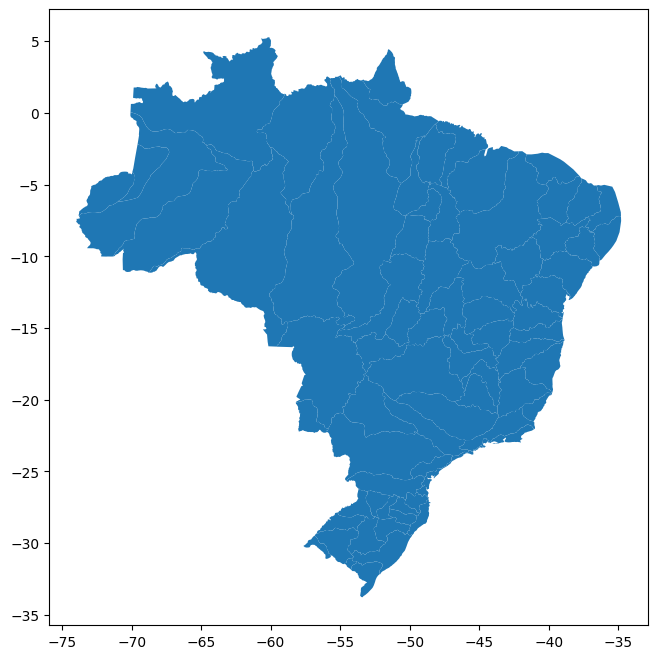

In [ ]:
df_shape_sub_brasil.plot(figsize=(8,8))

In [ ]:
map = leafmap.Map(center=[-30, -50], height="600px")

# Insere o mapa base da ESA, pode ser setado com outros, documentação
map.add_basemap("HYBRID")

df_geo_subbasin = df_shape_sub_brasil.loc[df_shape_sub_brasil.DNS_NU_SUB== 76 ].to_crs(epsg='4326')
map.add_gdf(df_geo_subbasin, layer_name="Ibicuí Basin", zoom_to_layer=True, fill_colors=["Black"])

#map.add_legend(builtin_legend="ESA_WorldCover")
#map.add_raster("/content/Bacia_Uruguai/SRTM_completo_ibi_1.tif", palette="terrain", layer_name="DEM1", nodata=0)
#map.add_raster("/content/Bacia_Uruguai/raster_clip.tif", palette="terrain", layer_name="DEM2", nodata=0)
#map

In [ ]:

wbt = leafmap.WhiteboxTools()
leafmap.whiteboxgui()

Decompressing WhiteboxTools_linux_musl.zip ...
WhiteboxTools package directory: /usr/local/lib/python3.10/dist-packages/whitebox


In [ ]:
# Esta importando direto do github, precisa vincular a earth-engine-api
wbt.feature_preserving_smoothing("/content/Bacia_Uruguai/raster_clip.tif", "/content/Bacia_Uruguai/SRTM_completo_ibi_smoothed.tif")

./whitebox_tools --run="FeaturePreservingSmoothing" --dem='/content/Bacia_Uruguai/raster_clip.tif' --output='/content/Bacia_Uruguai/SRTM_completo_ibi_smoothed.tif' --filter=11 --norm_diff=15.0 --num_iter=3 --max_diff=0.5 -v --compress_rasters=False

*****************************************
* Welcome to FeaturePreservingSmoothing *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
It appears that the DEM is in geographic coordinates. The z-factor has been updated to 0.000008985352.
Calculating normal vectors: 0%
Calculating normal vectors: 1%
Calculating normal vectors: 2%
Calculating normal vectors: 3%
Calculating normal vectors: 4%
Calculating normal vectors: 5%
Calculating normal vectors: 6%
Calculating normal vectors: 7%
Calculating normal vectors: 8%
Calculating normal vectors: 9%
Calculating normal vectors: 10%
Calculating normal vectors: 11%
Calculating normal vectors: 12%
Calculating nor

0

In [ ]:
# Gera um geojson para uso no script abaixo
df_geo_subbasin.to_file("basin.geojson", driver="GeoJSON")

In [ ]:
map.add_raster("/content/Bacia_Uruguai/SRTM_completo_ibi_smoothed.tif", palette="terrain", layer_name="Smoothed DEM", nodata=0)
wbt.hillshade("/content/Bacia_Uruguai/SRTM_completo_ibi_smoothed.tif", "/content/hillshade.tif", zfactor=10)
map.add_raster("/content/hillshade.tif", layer_name="Hillshade", nodata=0)
map.layers[-1].opacity = 0.5

map.add_geojson("/content/basin.geojson", layer_name="Watershed", info_mode=None)
map.add_colormap(cmap="terrain", vmin="0", vmax="536", label="Elevation (m)")
#metadata = leafmap.image_metadata("/content/Bacia_Uruguai/SRTM_completo_ibi_1.tif")
#metadata

# Generate direction flow and vectorize streamflow

#wbt.breach_depressions("/content/Bacia_Uruguai/SRTM_completo_ibi_smoothed.tif", '/content/Bacia_Uruguai/breached.tif')
#wbt.d8_pointer('/content/Bacia_Uruguai/breached.tif', '/content/Bacia_Uruguai/flow_direction.tif')
#wbt.d8_flow_accumulation('/content/Bacia_Uruguai/breached.tif', '/content/Bacia_Uruguai/flow_accumulation.tif')
#map.add_raster('/content/Bacia_Uruguai/flow_accumulation.tif', layer_name= "Flow Accumulation")
#wbt.extract_streams('/content/Bacia_Uruguai/flow_accumulation.tif', '/content/Bacia_Uruguai/streams.tif', threshold=5000)
#map.add_raster('/content/Bacia_Uruguai/streams.tif', layer_name="Streams")
#map.add_raster('/content/Bacia_Uruguai/streams.tif', layer_name="Streams")
#wbt.raster_streams_to_vector('/content/Bacia_Uruguai/streams.tif', d8_pntr='/content/Bacia_Uruguai/flow_direction.tif', output='/content/Bacia_Uruguai/stream.shp')
#leafmap.vector_set_crs(source='/content/Bacia_Uruguai/stream.shp', output='/content/Bacia_Uruguai/stream.shp', crs='EPSG:3857')
#map.add_shp('/content/Bacia_Uruguai/stream.shp')


#map

./whitebox_tools --run="Hillshade" --dem='/content/Bacia_Uruguai/SRTM_completo_ibi_smoothed.tif' --output='/content/hillshade.tif' --azimuth=315.0 --altitude=30.0 --zfactor='10' -v --compress_rasters=False

****************************
* Welcome to Hillshade     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Performing analysis: 0%
Performing analysis: 1%
Performing analysis: 2%
Performing analysis: 3%
Performing analysis: 4%
Performing analysis: 5%
Performing analysis: 6%
Performing analysis: 7%
Performing analysis: 8%
Performing analysis: 9%
Performing analysis: 10%
Performing analysis: 11%
Performing analysis: 12%
Performing analysis: 13%
Performing analysis: 14%
Performing analysis: 15%
Performing analysis: 16%
Performing analysis: 17%
Performing analysis: 18%
Performing analysis: 19%
Performing analysis: 20%
Performing analysis: 21%
Performing analysis: 22%
Performing analysis: 23%
Performing analysis: 24%
Performing analys

In [ ]:
map

Map(bottom=38828.0, center=[-30.145127183376115, -55.23925781250001], controls=(ZoomControl(options=['position…

## Download, load e merge dos metadados das estações da ANA

### **Vazão**

In [ ]:
meta_flow = download.metadata_ana_flow(folder='/content/Bacia_Uruguai',)
print('Arquivo de metadados de vazão foi salvo em: {}'.format(meta_flow))

# importar DataFrames dos metadados
df_meta_flow = load.metadata_ana_flow(file=meta_flow)  # vazões
print('\n Dataframe metadados Vazoes: ')
#print(df_meta_flow.head(15).to_string())

df_meta_flow = pd.DataFrame(df_meta_flow) #transforma em dataframe
df_meta_flow
#df_meta_flow.info() #informações do dataframe


Arquivo de metadados de vazão foi salvo em: /content/Bacia_Uruguai/metadata_ANA-flow_2024-02-27.txt

 Dataframe metadados Vazoes: 


Name CodEstacao Type  DrainageArea  SubBasin  \
0                               BORJA   10064000    1      115000.0        10   
1                           SAN REGIS   10070500    1      316000.0        10   
2                             REQUENA   10074800    1        4738.0        10   
3                         TAMISHIYACU   10075000    1        8985.0        10   
4                FRANCISCO DE ORELLAN   10080900    1           NaN        10   
...                               ...        ...  ...           ...       ...   
3766        PASO BORCHES, Rio Taçúari   89100000    1        1420.0        89   
3767         PASO DRAGON, Rio Taçúari   89150000    1        3560.0        89   
3768              VERGARA, arr. Parão   89250000    1        1110.0        89   
3769      PASO AVERIAS, Rio Cebollati   89400000    1        7850.0        89   
3770  TREITA Y TRÊS-RUTA 8, R. Olimar   89461000    1        4680.0        89   

                City    State   Responsible  Latitude  Longitude  StartDate  \
0               PERU     PERU  SENAMHI-PERU   -4.4700   -77.5500 1986-02-02   
1               PERU     PERU  SENAMHI-PERU   -4.5100   -73.9500 1994-05-16   
2               PERU     PERU  SENAMHI-PERU   -5.0300   -73.8300 1984-10-25   
3               PERU     PERU  SENAMHI-PERU   -4.0036   -73.1611 1983-10-02   
4               PERU     PERU  SENAMHI-PERU   -0.4731   -76.9825 2001-01-02   
...              ...      ...           ...       ...        ...        ...   
3766       LAVALLEJA  URUGUAI  DH - URUGUAI  -32.5303   -54.1314 2000-01-01   
3767     CERRO LARGO  URUGUAI  DH - URUGUAI  -32.7636   -53.7189 2000-01-01   
3768  TREINTA Y TRES  URUGUAI  DH - URUGUAI  -32.9425   -53.9269 2000-01-01   
3769       LAVALLEJA  URUGUAI  DH - URUGUAI  -33.6133   -54.3294 2000-01-01   
3770  TREINTA Y TRES  URUGUAI  DH - URUGUAI  -33.2419   -54.4019 2000-01-01   

        EndDate  NYD    MD  N_YWOMD  YWMD  
0    2013-03-15   28  27.6       17  39.3  
1    2005-10-17   12   0.1       10  16.7  
2    2005-10-17   22   8.6       15  31.8  
3    2010-09-13   28   5.0       23  17.9  
4    2005-10-29    5   0.1        3  40.0  
...         ...  ...   ...      ...   ...  
3766 2008-12-31    9   4.5        6  33.3  
3767 2008-12-31    9   0.0        9   0.0  
3768 2008-12-31    9   3.4        6  33.3  
3769 2008-12-31    9   1.4        3  66.7  
3770 2008-12-31    9  17.0        3  66.7  

[3771 rows x 16 columns]

In [ ]:
# Transforma a coluna CodEstacao em inteiro
df_meta_flow = df_meta_flow.astype({"CodEstacao": int})

list_station = [76800000] # Estação de vazão selecionada

df = df_meta_flow[df_meta_flow.CodEstacao.isin(list_station)] # filtra Dataframe da estação de vazão selecionada
df

Name  CodEstacao Type  DrainageArea  SubBasin    City  \
3406  PASSO MARIANO PINTO    76800000    1       42500.0        76  ITAQUI   

                  State Responsible  Latitude  Longitude  StartDate  \
3406  RIO GRANDE DO SUL         ANA  -29.3092   -56.0553 1953-05-15   

        EndDate  NYD   MD  N_YWOMD  YWMD  
3406 2019-10-31   67  2.7       56  16.4

In [ ]:
# ESSA PARTE ESTAVA BAIXANDO DIRETO PARA MEU GDRIVE...
# NESTE CASO, ADICIONEI UMA TIME-SERIE DIRETAMENTE DO GITHUB


# download de dados de chuva. Definir qual é a estação, em caso de estação especifica ou usar o range caso precisa gerar uma lista de dados
!mkdir -p "/content/Bacia_Uruguai/Dados_Flow" #cria pasta no drive para baixar dados dentro
#OBS: DEIXAR COMENTADO PARA BAIXAR OS DADOS SOMENTE QUANDO NECESSARIOS, SENÃO QUANDO EXECUTA TUDO, JÁ COMEÇA BAIXAR
list_station = ['76800000']
# Onde tem o ponto nas aspas do folder é o diretório caminho do/dos downloads, pode usar diretório do Drive, ou Github ou localhost
for j in range(len(list_station)): #range coloca cada vez um codigo de estação na lista pro download
  file_flow = download.ana_flow(code= list_station[j],folder='/content/Bacia_Uruguai/Dados_Flow')
  print('Arquivo salvo em: {}'.format(file_flow))


#leitura da serie escolhida
df_flow = pd.read_csv("/content/Bacia_Uruguai/Dados_Flow/ANA-flow_76800000_1941-2023__by-2024-02-27.txt", sep=";")
df_flow

100%|██████████| 1/1 [00:14<00:00, 14.21s/it]


Arquivo salvo em: /content/Bacia_Uruguai/Dados_Flow/ANA-flow_76800000_1941-2023__by-2024-02-27.txt


Date     Flow
0      1941-01-01      NaN
1      1941-01-02      NaN
2      1941-01-03      NaN
3      1941-01-04      NaN
4      1941-01-05      NaN
...           ...      ...
30157  2023-07-27  816.231
30158  2023-07-28  736.334
30159  2023-07-29  680.988
30160  2023-07-30  638.704
30161  2023-07-31  586.443

[30162 rows x 2 columns]

#### **Estatisticas básicas da série-temporal de vazão (Estação 76800000 Passo Mariano Pinto)**

In [ ]:
statistics = df_flow['Flow'].describe()

# Imprimir as estatísticas
print(statistics)

count    21702.000000
mean       883.444750
std        985.454756
min         11.445500
25%        229.841000
50%        494.751000
75%       1174.005000
max       8417.720000
Name: Flow, dtype: float64


### **Precipitação**

In [ ]:
meta_prec = download.metadata_ana_prec(folder='/content/Bacia_Uruguai',)
print('Arquivo de metadados de precipitação foi salvo em: {}'.format(meta_prec))


# importar DataFrames dos metadados
df_meta_prec = load.metadata_ana_prec(file=meta_prec)  # vazões
print('\n Dataframe metadados precipitacao: ')
#print(df_meta_flow.head(15).to_string())

df_meta_prec = pd.DataFrame(df_meta_prec) #transforma em dataframe
df_meta_prec
#df_meta_flow.info() #informações do dataframe


Arquivo de metadados de precipitação foi salvo em: /content/Bacia_Uruguai/metadata_ANA-prec_2024-02-27.txt

 Dataframe metadados precipitacao: 


Name CodEstacao Type  SubBasin         City  \
0                    SALINÓPOLIS   00047000    2        32  SALINÓPOLIS   
1                    SALINÓPOLIS   00047002    2        32  SALINÓPOLIS   
2                         CURUÇA   00047003    2        32       CURUÇA   
3                      PRIMAVERA   00047004    2        32    PRIMAVERA   
4                         MARUDA   00047005    2        32    MARAPANIM   
...                          ...        ...  ...       ...          ...   
11971  NOVA ESPERANÇA/MARCO BV-8   08461000    2        14    PACARAIMA   
11972    MISSÃO AUARIS - JUSANTE   08464001    2        14    BOA VISTA   
11973         WILLIAM KRAANPLEIN   08555060    2        90     SURINAME   
11974                   ZANDERIJ   08555096    2        90     SURINAME   
11975    FAZENDA BANDEIRA BRANCA   08560000    2        14     UIRAMUTA   

          State Responsible  Latitude  Longitude  StartDate    EndDate  NYD  \
0          PARÁ       INMET   -0.6500   -47.5500 1958-01-01 1964-12-31    7   
1          PARÁ         ANA   -0.6231   -47.3536 1977-12-09 2019-08-31   43   
2          PARÁ         ANA   -0.7375   -47.8536 1981-07-01 2019-07-31   39   
3          PARÁ         ANA   -0.9294   -47.0994 1982-02-18 2019-08-31   38   
4          PARÁ         ANA   -0.6336   -47.6583 1989-08-21 2019-07-31   31   
...         ...         ...       ...        ...        ...        ...  ...   
11971   RORAIMA         ANA    4.4883   -61.1297 1984-03-23 2019-06-30   36   
11972   RORAIMA         ANA    4.0031   -64.4431 1995-04-01 2019-06-30   25   
11973  SURINAME    SURINAME    5.8000   -55.1667 1935-08-01 1948-12-31   14   
11974  SURINAME    SURINAME    5.4700   -55.2000 2009-01-31 2010-01-31    2   
11975   RORAIMA         ANA    4.6306   -60.4706 1976-01-01 1996-02-29   21   

         MD  N_YWOMD   YWMD  
0      25.0        0  100.0  
1       3.5       35   18.6  
2       2.4       29   25.6  
3       0.0       35    7.9  
4       5.0       20   35.5  
...     ...      ...    ...  
11971  12.3       13   63.9  
11972   4.2       15   40.0  
11973   9.2        7   50.0  
11974  96.7        0  100.0  
11975   5.6       12   42.9  

[11976 rows x 15 columns]

In [ ]:
df_meta_prec = df_meta_prec.astype({"CodEstacao": int})
prec_station = [3054007] # Estação de precipitação selecionada

df_prec = df_meta_prec[df_meta_prec.CodEstacao.isin(prec_station)] # filtra Dataframe da estação de precipitação selecionada
df_prec


Name  CodEstacao Type  SubBasin            City  \
11742  ROSÁRIO DO SUL     3054007    2        76  ROSÁRIO DO SUL   

                   State Responsible  Latitude  Longitude  StartDate  \
11742  RIO GRANDE DO SUL         ANA  -30.2469   -54.9175 1943-04-11   

         EndDate  NYD   MD  N_YWOMD  YWMD  
11742 2019-10-31   77  6.2       58  24.7

In [ ]:
# download de dados de chuva. Definir qual é a estação, em caso de estação especifica ou usar o range caso precisa gerar uma lista de dados
!mkdir -p "/content/Bacia_Uruguai/Dados_Prec" #cria pasta no drive para baixar dados dentro
#OBS: DEIXAR COMENTADO PARA BAIXAR OS DADOS SOMENTE QUANDO NECESSARIOS, SENÃO QUANDO EXECUTA TUDO, JÁ COMEÇA BAIXAR
prec_station = ['03054007']
# Onde tem o ponto nas aspas do folder é o diretório caminho do/dos downloads, pode usar diretório do Drive, ou Github ou localhost
for j in range(len(prec_station)): #range coloca cada vez um codigo de estação na lista pro download
  file_prec = download.ana_prec(code= prec_station[j],folder='/content/Bacia_Uruguai/Dados_Prec')
  print('Arquivo salvo em: {}'.format(file_prec))


#leitura da serie escolhida
df_prec = pd.read_csv("/content/Bacia_Uruguai/Dados_Prec/ANA-prec_03054007_1943-2023__by-2024-02-27.txt", sep=";")
df_prec

100%|██████████| 1/1 [00:09<00:00,  9.15s/it]


Arquivo salvo em: /content/Bacia_Uruguai/Dados_Prec/ANA-prec_03054007_1943-2023__by-2024-02-27.txt


Date  Prec
0      1943-04-01   NaN
1      1943-04-02   NaN
2      1943-04-03   NaN
3      1943-04-04   NaN
4      1943-04-05   NaN
...           ...   ...
29368  2023-08-27   0.0
29369  2023-08-28   0.0
29370  2023-08-29   0.0
29371  2023-08-30   0.0
29372  2023-08-31   0.0

[29373 rows x 2 columns]

#### **Estatisticas básicas da série-temporal de precipitação**

In [ ]:
statistics_p = df_prec['Prec'].describe()

# Imprime as estatísticas
print(statistics_p)

count    27502.00000
mean         4.06357
std         13.19587
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max        198.80000
Name: Prec, dtype: float64


### **Merge dos dataframes**

In [ ]:
# Junta os dataframes com as datas iguais
df_merged = pd.merge(df_prec, df_flow, on='Date')
df_merged

Date  Prec     Flow
0      1943-04-01   NaN      NaN
1      1943-04-02   NaN      NaN
2      1943-04-03   NaN      NaN
3      1943-04-04   NaN      NaN
4      1943-04-05   NaN      NaN
...           ...   ...      ...
29337  2023-07-27   0.0  816.231
29338  2023-07-28   0.0  736.334
29339  2023-07-29   0.0  680.988
29340  2023-07-30   0.0  638.704
29341  2023-07-31   0.0  586.443

[29342 rows x 3 columns]

## Reamostragem de série temporal, com resample

Nesta etapa os gaps de dados foram interpolados linearmente

### esta etapa interpola os gaps de dados, pode ser ajustada conforme apresentado abaixo

In [ ]:
# docstring
help(resample.interpolate_gaps)

Help on function interpolate_gaps in module gespla.resample:

interpolate_gaps(dataframe, var_field, size, freq='day', date_field='Date', kind='cubic')
    This function interpolates gaps on a time series. The maximum gap length for interpolation can
    be defined in the size= parameter. The time scale of series are not relevant.
    
    :param dataframe: pandas DataFrame object. The date field must be in a column, not the index.
    :param var_field: string head of the variable field.
    :param date_field: string head of the date field. Default: 'Date'
    :param size: integer number for maximum gap length to fill. Default is 4.
    :param freq: string of time scale of time series. Options:
    
    year
    month
    day
    hour
    
    :param kind: string of interpolation tipe (it uses scipy.interpolate.interp1d)
    Default: 'cubic' - cubic spline
    
    Options (from scipy docs - https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html )
    'lin

           Date  Original  Interpolation
7640 1964-03-01   59.1071        59.1071
7641 1964-03-02   64.2724        64.2724
7642 1964-03-03   69.6264        69.6264
7643 1964-03-04   79.4443        79.4443
7644 1964-03-05   80.8930        80.8930
7645 1964-03-06  108.9060       108.9060
7646 1964-03-07  144.2260       144.2260
7647 1964-03-08  188.0040       188.0040
7648 1964-03-09  175.5620       175.5620
7649 1964-03-10  151.8070       151.8070


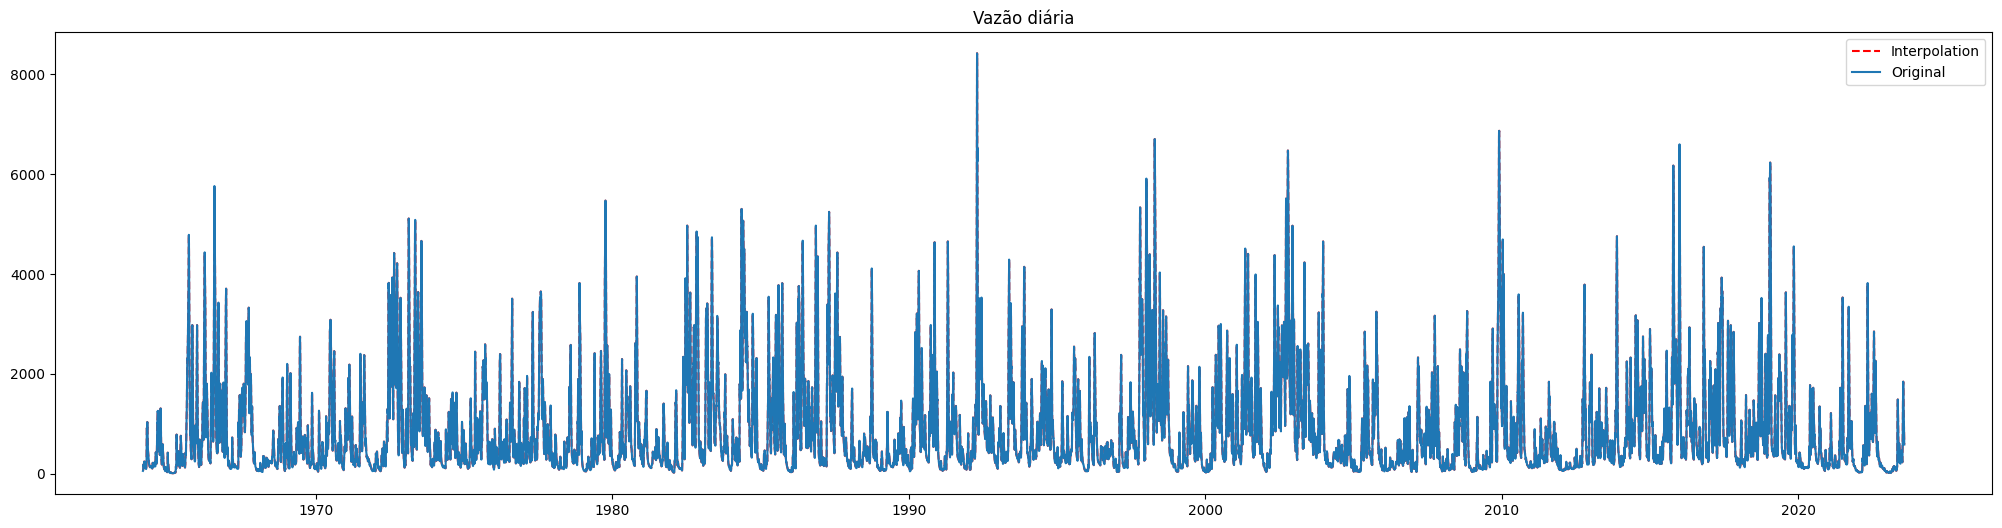

In [ ]:
# obter um novo dataframe com os valores originais e interpolados (Vazão)
df_fill = resample.interpolate_gaps(
    dataframe=df_merged,
    var_field='Flow',
    size=60, # size é um parâmetro de tamanho máximo de falha
    freq='day',
    date_field='Date',
    kind='linear')
print(df_fill.head(10).to_string())


# visualizar a diferença entre os dados originais e interpolados
window = 100000
plt.figure(figsize=(25,6))
plt.plot(df_fill['Date'].head(window), df_fill['Interpolation'].head(window), 'r--')
plt.plot(df_fill['Date'].head(window), df_fill['Original'].head(window))
plt.legend(['Interpolation', 'Original'])
plt.title('Vazão diária')
plt.show()

Reamostragem diaria para mensal

          Date  Period_Count  Count           Sum          Mean          Min           Max          Q25          Q50           Q75
703 2022-10-01            31     31  4.305924e+08  1.389008e+07  11199945.60  1.946307e+07  12406262.40  13096771.20  1.452220e+07
704 2022-11-01            30     30  2.830288e+08  9.434294e+06   6521299.20  1.319000e+07   8460901.44   8896348.80  1.046663e+07
705 2022-12-01            31     31  1.340372e+08  4.323782e+06   2356966.08  6.592199e+06   3377972.16   4295436.48  5.264970e+06
706 2023-01-01            31     31  8.409044e+07  2.712595e+06   2216471.04  3.768690e+06   2333361.60   2598609.60  2.952314e+06
707 2023-02-01            28     28  8.984579e+07  3.208778e+06   2170393.92  5.103337e+06   2549543.04   3004283.52  3.571355e+06
708 2023-03-01            31     31  2.649405e+08  8.546467e+06   4599676.80  1.309677e+07   6000199.20   7995775.68  1.120116e+07
709 2023-04-01            30     30  2.380561e+08  7.935203e+06   5428503.36  1.245

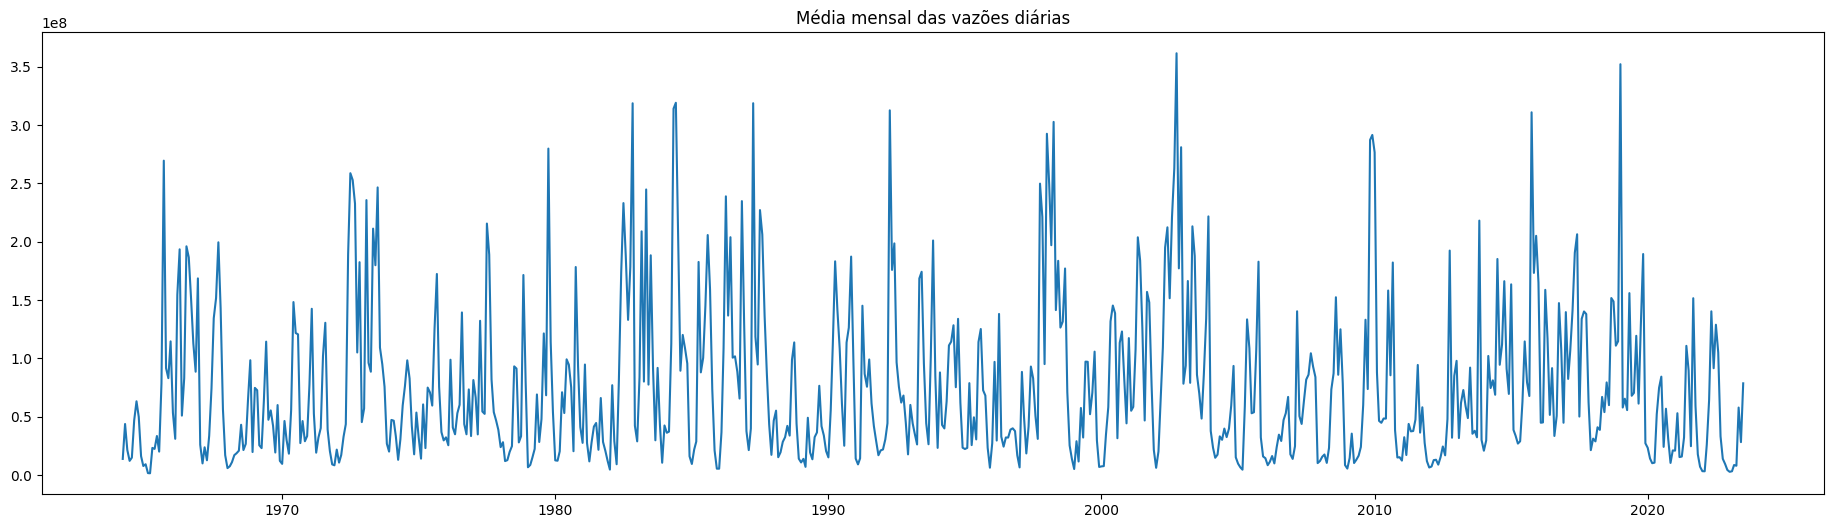

In [ ]:
"""
** Flow Units **
    The daily time series unit is considered to be volume/ seconds.
    Therefore, for monthly accumulation, it is converted first in volume/day
    multiplying by 86400.
"""

df_flow_d2m = resample.d2m_flow(dataframe=df_fill, var_field='Interpolation')
print(df_flow_d2m.tail(10).to_string())

#visualização de reamostragem diaria para mensal
plt.figure(figsize=(23,6))
plt.plot(df_flow_d2m['Date'], df_flow_d2m['Mean'])
plt.title('Média mensal das vazões diárias')
plt.show()

#plt.figure(figsize=(23,5))
#plt.plot(df_flow_d2m['Date'], df_flow_d2m['Q25'])
#plt.title('Q25 mensal')
#plt.show()
#
#plt.figure(figsize=(23,5))
#plt.plot(df_flow_d2m['Date'], df_flow_d2m['Q50'])
#plt.title('Q50 mensal')
#plt.show()
#
#plt.figure(figsize=(23,5))
#plt.plot(df_flow_d2m['Date'], df_flow_d2m['Q75'])
#plt.title('Q75 mensal')
#plt.show()
##plt.legend(['Mean', 'Q25', 'Q50', 'Q75'])



## Decomposição da série temporal e análises de ACF e PACF(série original e diferenciada)

In [ ]:
df_flow_d2m_recortado = df_flow_d2m[['Date', 'Mean']]
df_flow_d2m_recortado

Date          Mean
0   1964-03-01  1.379481e+07
1   1964-04-01  4.372859e+07
2   1964-05-01  2.143295e+07
3   1964-06-01  1.212597e+07
4   1964-07-01  1.492699e+07
..         ...           ...
708 2023-03-01  8.546467e+06
709 2023-04-01  7.935203e+06
710 2023-05-01  5.782253e+07
711 2023-06-01  2.817668e+07
712 2023-07-01  7.860225e+07

[713 rows x 2 columns]

### **Teste de Dickey-Fuller Aumentado (ADF)**

O teste de Dickey-Fuller Aumentado (ADF) é baseado em um modelo de regressão que testa a presença de uma raiz unitária em uma série temporal. A equação do teste ADF é a seguinte:

$\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{p-1} \phi_i \Delta y_{t-i} + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + \epsilon_t
$

**Onde:**
- $\Delta y_t$ é a diferença de primeira ordem da série temporal original.
- $\alpha$ é o termo constante.
- $\beta$ é o coeficiente associado ao tempo (tendência linear).
- $\gamma$ é o coeficiente associado ao valor defasado da série temporal.
- $\phi_i$ são os coeficientes autoregressivos que representam a dependência da diferença da série temporal com seus próprios valores defasados.
- $\theta_i$ são os coeficientes de média móvel que representam a dependência da diferença da série temporal com os resíduos defasados.
- $\epsilon_t$ é o termo de erro no tempo atual.



In [ ]:
result_adf = adfuller(df_flow_d2m_recortado['Mean'])
print('Estatística ADF:', result_adf[0])
print('Valor p:', result_adf[1])
print('Valores críticos:')
for key, value in result_adf[4].items():
    print('\t', key, ':', value)

Estatística ADF: -12.255048142658397
Valor p: 9.351528653807288e-23
Valores críticos:
	 1% : -3.439580754053961
	 5% : -2.865613606467485
	 10% : -2.568939269723711


Com base nos valores do teste de Dickey-Fuller Aumentado (ADF) podemos tirar as seguintes conclusões:

O valor da estatística ADF é $-12.21$. Esse valor é menor do que todos os valores críticos em níveis de significância de $1\%$, $5\%$ e $10\%$. Isso indica que a estatística ADF está além dos limites críticos e sugere fortemente que podemos **rejeitar** a hipótese nula de que a série temporal possui uma raiz unitária.

O p-value é $1.17^{-22}$, o que é muito menor que um nível de significância comum, como $0.05$. Isso reforça a evidência de rejeitar a hipótese nula de uma raiz unitária na série temporal. Em outras palavras, a série é considerada **estacionária**.

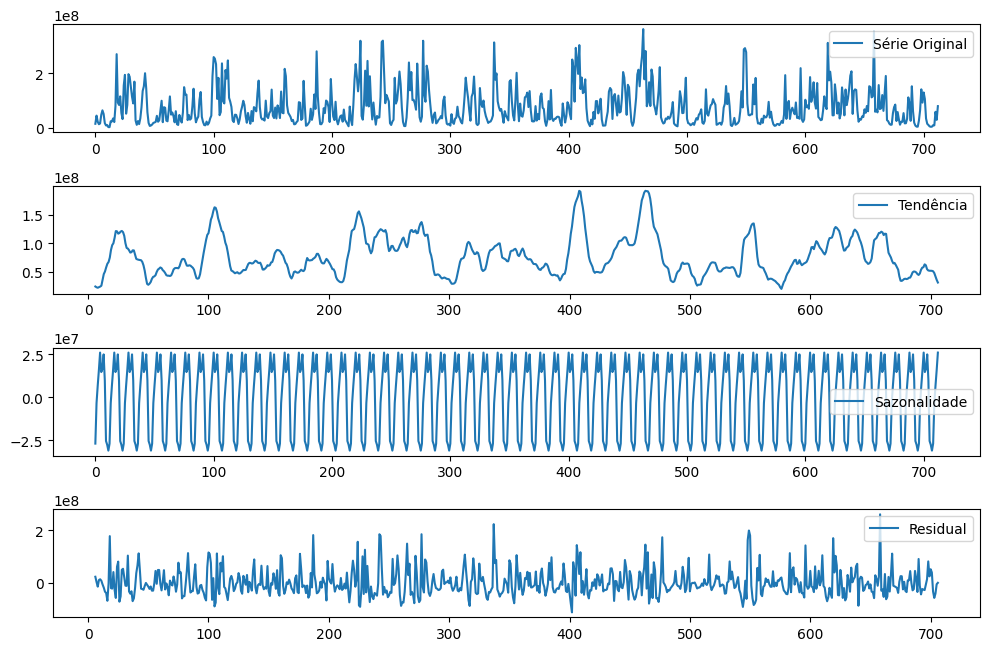

In [ ]:
# Decomposição da série temporal
decomposition = seasonal_decompose(df_flow_d2m_recortado['Mean'], model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
observed = decomposition.observed
# Plotar os componentes da decomposição
plt.figure(figsize=(10, 8))
plt.subplot(511)
plt.plot(df_flow_d2m_recortado['Mean'], label='Série Original')
plt.legend(loc='best')
plt.subplot(512)
plt.plot(trend, label='Tendência')
plt.legend(loc='best')
plt.subplot(513)
plt.plot(seasonal, label='Sazonalidade')
plt.legend(loc='best')
plt.subplot(514)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

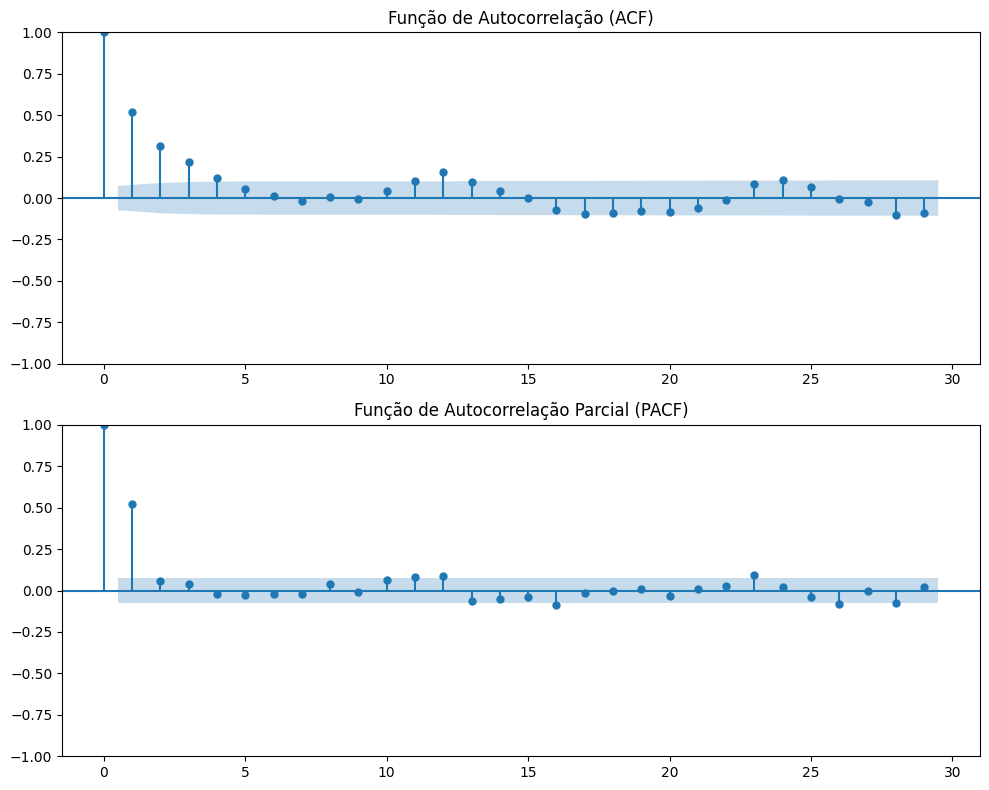

In [ ]:
# Plotar ACF e PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_flow_d2m_recortado['Mean'], ax=ax[0], title='Função de Autocorrelação (ACF)')
plot_pacf(df_flow_d2m_recortado['Mean'], ax=ax[1], title='Função de Autocorrelação Parcial (PACF)')
plt.tight_layout()
plt.show()

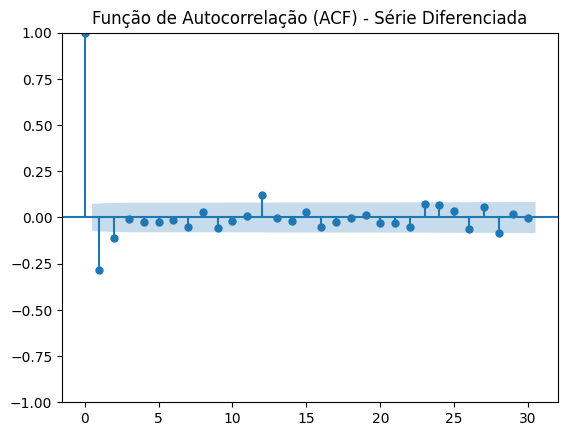

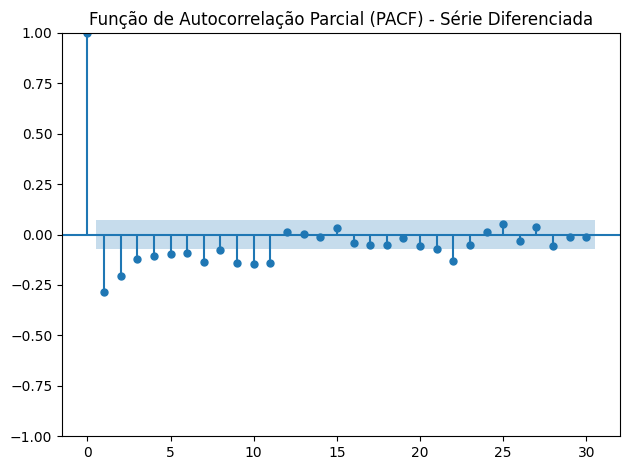

In [ ]:
# série diferenciada
differenced_series = df_flow_d2m_recortado['Mean'].diff()

plot_acf(differenced_series.dropna(), lags=30, title='Função de Autocorrelação (ACF) - Série Diferenciada')
plot_pacf(differenced_series.dropna(), lags=30, title='Função de Autocorrelação Parcial (PACF) - Série Diferenciada')
plt.tight_layout()
plt.show()

## **Modelo ARIMA (Vazão)**

### Arima fitted

In [ ]:
df_flow_d2m_recortado

Date          Mean
0   1964-03-01  1.379481e+07
1   1964-04-01  4.372859e+07
2   1964-05-01  2.143295e+07
3   1964-06-01  1.212597e+07
4   1964-07-01  1.492699e+07
..         ...           ...
708 2023-03-01  8.546467e+06
709 2023-04-01  7.935203e+06
710 2023-05-01  5.782253e+07
711 2023-06-01  2.817668e+07
712 2023-07-01  7.860225e+07

[713 rows x 2 columns]

p: 0
d: 0
q: 0
AIC: 25244.63508625129
BIC: 25253.32635897295
                               SARIMAX Results                                
Dep. Variable:                   Mean   No. Observations:                  570
Model:                          ARIMA   Log Likelihood              -12620.318
Date:                Tue, 27 Feb 2024   AIC                          25244.635
Time:                        20:37:07   BIC                          25253.326
Sample:                             0   HQIC                         25248.026
                                - 570                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.712e+07   1.65e+09      0.047      0.963   -3.15e+09     3.3e+09
sigma2      2.706e+18      0.030   9.04e+19      0.000    2.71e+18    

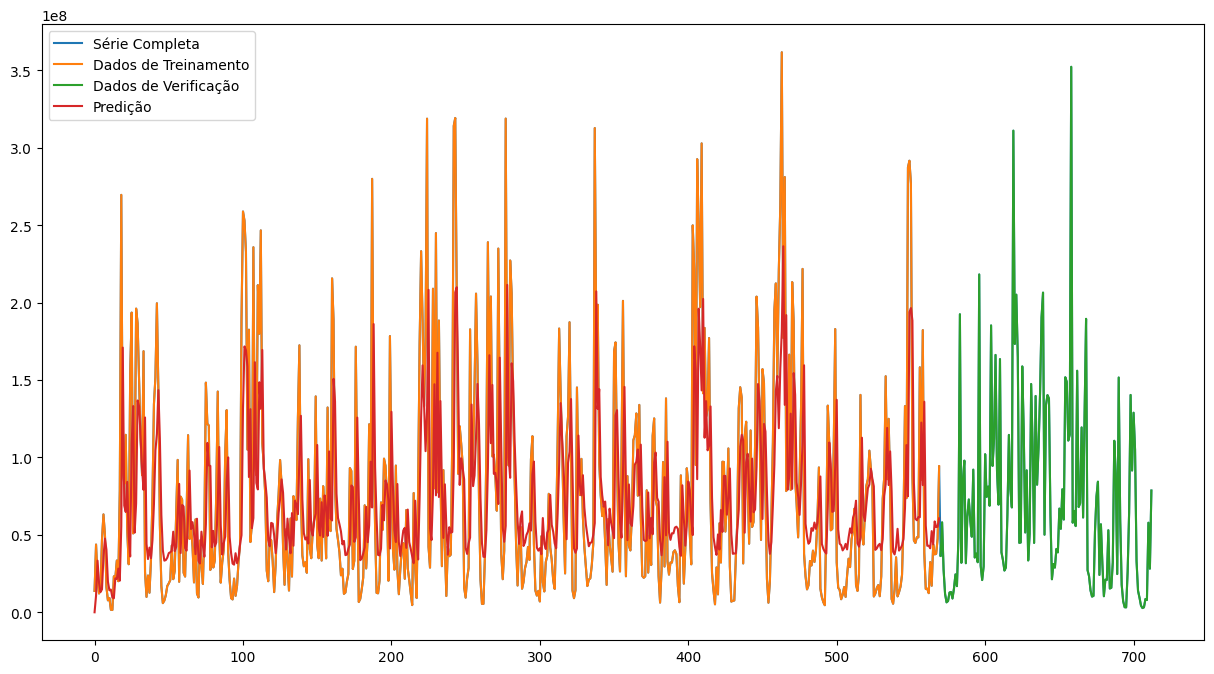

In [ ]:

from statsmodels.tsa.arima.model import ARIMAResultsWrapper
# Divide a série em conjuntos de treinamento e teste
train_size = int(len(df_flow_d2m_recortado) * 0.8)
train = df_flow_d2m_recortado[:train_size]
test = df_flow_d2m_recortado[train_size:]

# Definir as faixas de valores para p, d e q, neste caso coloquei um range pequeno para não ficar demorado
p_values = range(0, 3)  # Faixa de valores para p
d_values = range(0, 3)  # Faixa de valores para d
q_values = range(0, 3)  # Faixa de valores para q

best_aic = float("inf")
best_bic = float("inf")
best_model = None
best_order = None

# Iterar por todas as combinações de p, d e q
for p in p_values:
    for d in d_values:
        for q in q_values:
                  # Ajustar o modelo ARIMA
                  model = ARIMA(train['Mean'], order=(p, d, q))
                  try:
                      model_fit = model.fit()
                      # Calcular AIC e BIC
                      aic = model_fit.aic
                      bic = model_fit.bic
                      print("p:",p)
                      print("d:",d)
                      print("q:",q)
                      print("AIC:",aic)
                      print("BIC:",bic)
                      print(model_fit.summary())
                      # Verifica se o modelo atual é o melhor até agora, critério menor AIC e menor BIC
                      if aic < best_aic and bic < best_bic:
                          best_aic = aic
                          best_bic = bic
                          best_model = model_fit
                          best_order = (p, d, q)
                  except:
                      continue

# Imprimir o melhor modelo e seus valores de AIC e BIC
print("Melhor modelo ARIMA:", best_order)
print("Melhor AIC:", best_aic)
print("Melhor BIC:", best_bic)
print("Melhor modelo ARIMA:", best_model.summary(alpha=0.05, start=None))
# Fazer previsões usando o melhor modelo
predictions = best_model.predict(steps=len(train))

# Plotar a série, dados de treinamento, dados de teste e previsões
plt.figure(figsize=(15, 8))
plt.plot(df_flow_d2m_recortado.index, df_flow_d2m_recortado['Mean'], label='Série Completa')
plt.plot(train.index, train['Mean'], label='Dados de Treinamento')
plt.plot(test.index, test['Mean'], label='Dados de Verificação')
plt.plot(train.index, predictions, label='Predição')
plt.legend(loc='best')
plt.show()

### **White noise analysis**

O ruído branco é um sinal onde a média é 0, a variância é uma constante independente do tempo e a autocorrelação da serie temporal com qualquer defasagem temporal é 0. Portanto, não existe autocorrelação significativa entre a série de ruído branco e qualquer versão defasada no tempo.

Porque é importante?
Uma das suposições da regressão linear é que seus erros são independentes por natureza. Usando os testes é possivel inferir que o modelo de regressão linear está bem ajustado.

Nesta seção será realizada o teste de Ljung-Box para detectar se a serie temporal de vazão é ruido branco ou não.


Train Data Shape: (570, 2)
Predictions Shape: (570,)


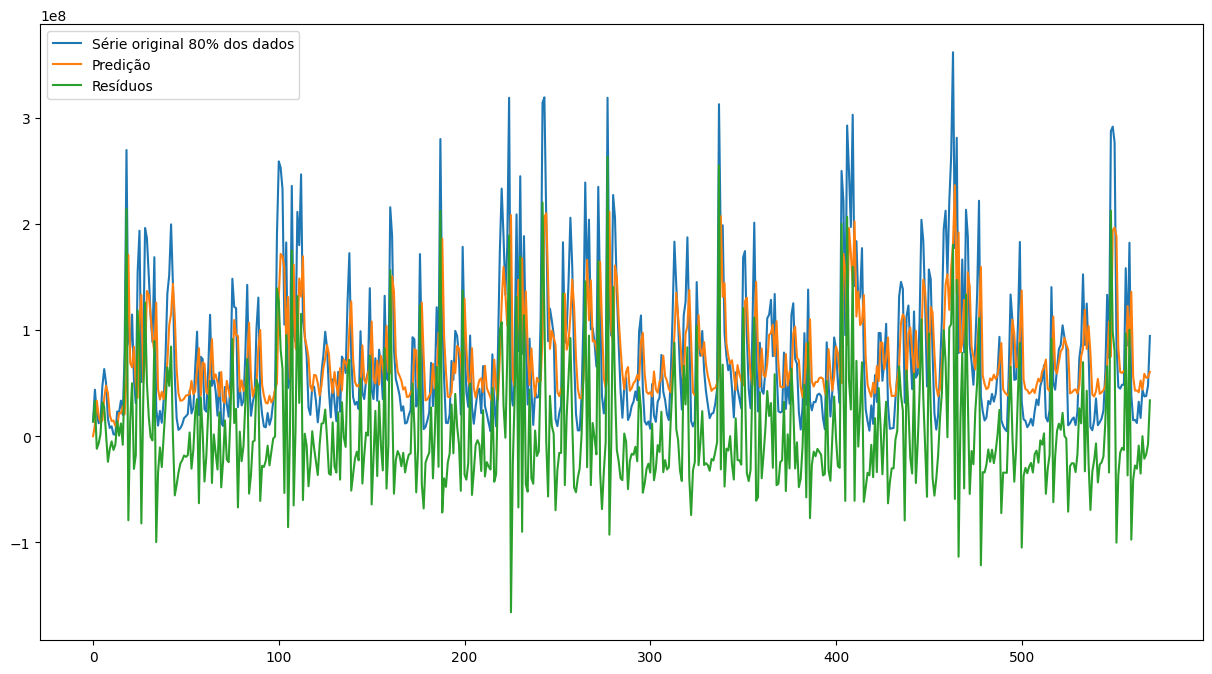

In [ ]:

print('Train Data Shape:', train.shape) # .shape obtem a dimensão do array, usado para não plotar serie de mesmo valor de index
print('Predictions Shape:', predictions.shape)

train_values = train['Mean'].values #.values extrai valores do df e converte para ndarray
prediction_values = predictions.values

# resíduos
resi_ = train_values - prediction_values

plt.figure(figsize=(15, 8))
plt.plot(train.index, train['Mean'], label='Série original 80% dos dados')
plt.plot(train.index, predictions, label='Predição')
plt.plot(train.index, resi_, label='Resíduos')
plt.legend(loc='best')
plt.show()

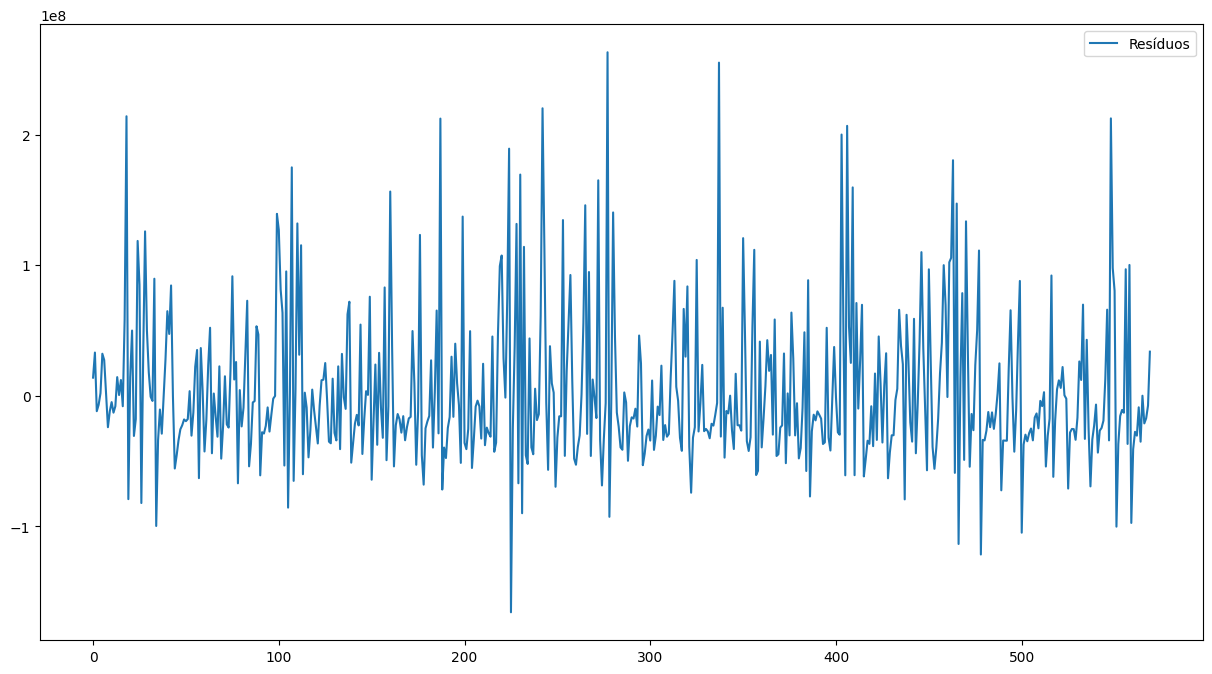

In [ ]:
# plotagem dos residuos
plt.figure(figsize=(15, 8))
plt.plot(train.index, resi_, label='Resíduos')
plt.legend(loc='best')
plt.show()

Text(0.5, 1.0, 'Histograma dos resíduos')

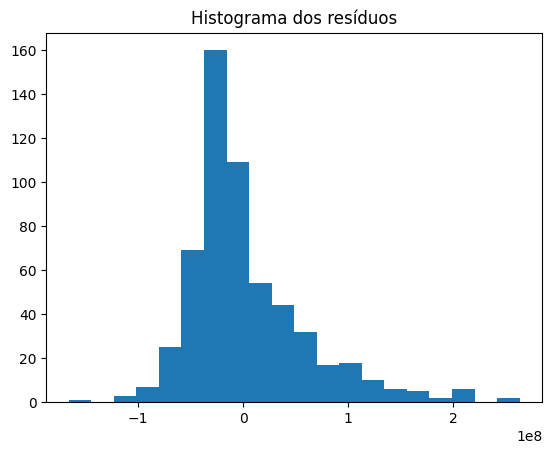

In [ ]:
plt.hist(resi_, bins=20)
plt.title('Histograma dos resíduos')

Para realizar o teste de Ljung-Box foram definidas as seguintes hipóteses:

Hipótese nula: Não há autocorrelação entre o sinal e sua versão defasada;

Hipótese alternativa: Existe autocorrelação significativa entre o sinal e sua versão defasada.

Sendo que, para inferir que a série temporal é de ruido branco, não deve ser rejeitada a hipótese nula com $α=5%$, ou seja, se $p-valor$ for maior que $0,05$.



### **Teste de Dickey-Fuller Aumentado (ADF)**

In [ ]:
result = adfuller(resi_)
print('Estatística ADF:', result[0])
print('Valor p:', result[1])
print('Valores críticos:')
for key, value in result[4].items():
    print('\t', key, ':', value)

Estatística ADF: -24.30795856767219
Valor p: 0.0
Valores críticos:
	 1% : -3.4418948967017475
	 5% : -2.8666329082535222
	 10% : -2.569482366838501


### **Teste de Ljung-Box**

In [ ]:
results = acorr_ljungbox(best_model.resid, lags=[1], return_df=True)
results

lb_stat  lb_pvalue
1  0.248578   0.618078

O teste de Ljung-Box apresentou p-value acima de 0.05, ou seja, o modelo não está apto a gerar previsões da série

### **AutoARIMA**

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm
model_auto_arima = pm.auto_arima(train['Mean'], seasonal=True, trace=True, error_action='ignore', d=1, n_fits=20 )

# Imprimir os parâmetros do modelo selecionado
print(model_auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22096.181, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22062.084, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22039.575, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22094.184, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21975.001, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21976.783, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21971.825, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22003.358, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=21976.529, Time=0.48 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=21984.773, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=1.00 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 9.558 seconds
                           

[0.61807801 0.85310416 0.85903384 0.94266397 0.92873108 0.91183823
 0.85168121 0.808084   0.71915418 0.77022991 0.73976913 0.05261735
 0.0713006  0.09853801 0.13183392 0.08197154 0.06603522 0.07771531
 0.09477989 0.06554164]


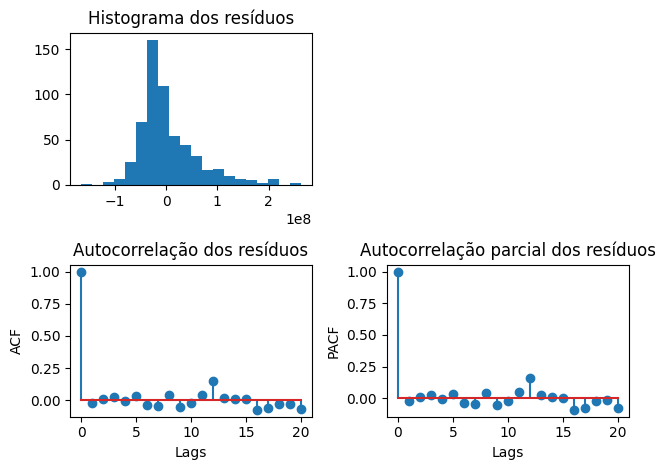

In [ ]:
# Obtenha os resíduos do modelo ajustado
residuals = best_model.resid

# Visualize os resíduos

plt.subplot(2, 2, 1)
plt.hist(residuals, bins=20)
plt.title('Histograma dos resíduos')

# Autocorrelação
lags =20
acf_vals = acf(residuals, nlags=lags, alpha=0.05, qstat=True)
#acf_vals = acf(residuals, nlags=lags, qstat=True)
qstat = acf_vals[3]
print(qstat)
plt.subplot(2, 2, 3)
plt.stem(range(lags+1), acf_vals[0])
plt.title('Autocorrelação dos resíduos')
plt.xlabel('Lags')
plt.ylabel('ACF')

# Autocorrelação parcial
pacf_vals = pacf(residuals, nlags=lags, alpha=0.05)
plt.subplot(2, 2, 4)
plt.stem(range(lags+1), pacf_vals[0])
plt.title('Autocorrelação parcial dos resíduos')
plt.xlabel('Lags')
plt.ylabel('PACF')

plt.tight_layout()
plt.show()

#### **Esta seção usa classes desenvolvidas pela GESPLA**

ValueError: x and y must have same first dimension, but have shapes (143,) and (142,)

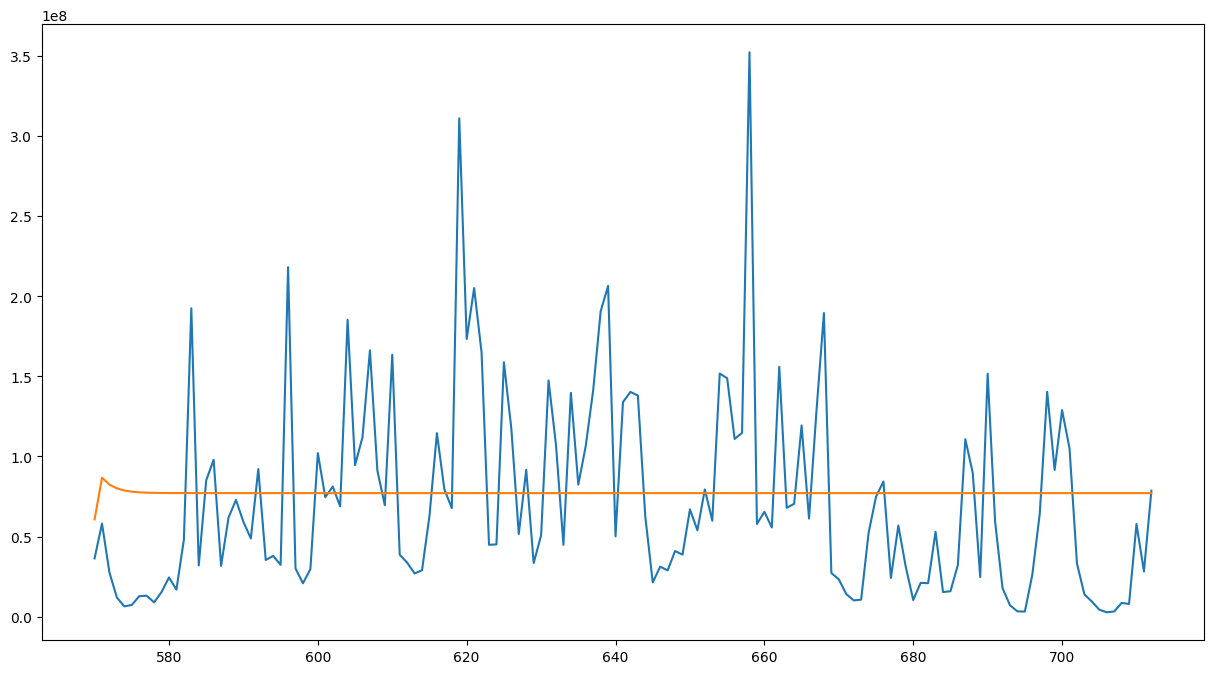

In [ ]:
# Tentativa falha de gerar previsão dos dados da serie de vazão
forecast = best_model.forecast(steps=142)
predictions = best_model.predict(start=train.index[-1], end=train.index[-1] + len(test)-1)
plt.figure(figsize=(15, 8))
plt.plot(test.index, test['Mean'], label='Dados de Verificação')
plt.plot(test.index, predictions, label='Previsões')
plt.plot(test.index, forecast, label='Forecast')
plt.legend(loc='best')
plt.show()

Série de vazões normalizada pelo método máx-mín

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normalizando apenas a coluna 'dados'
df_flow_d2m_recortado['Q_normalizada'] = scaler.fit_transform(df_flow_d2m_recortado[['Mean']])

print(df_flow_d2m_recortado)

In [ ]:
# obter um dicionário de meses (chaves em inglês) com séries agregadas por mês
by_month = resample.group_by_month(dataframe=df_flow_d2m_recortado, var_field='Q_normalizada')
print(type(by_month))

# Acessar chaves do dicionário pelo nome do mês (em inglês)
#print(by_month['January'].head())
#print()
#print(by_month['November'].head())

tpl = ('January', 'February', 'March', 'April', 'May', 'June', 'July',
        'August', 'September', 'October', 'November', 'December')
xlst = []
ylst = []
for i in range(len(tpl)):
    y = by_month[tpl[i]]['Q_normalizada'].values[:]
    x = (i + 1) + (y * 0)
    plt.plot(x, y, 'bo', alpha=0.04)
    xlst.append(x[0])
    ylst.append(y.mean())
plt.title('Padrão mensal de vazões normalizada')
#plt.yscale('log')
plt.plot(xlst, ylst, 'k')
plt.show()

Para calcular curva de permanencia e distribuição de densidade de probabilidade

In [ ]:
# para vazão e clima, usar com parâmetro zero=True
df_freq_flow_m = tsa.frequency(dataframe=df_flow_d2m_recortado, var_field='Q_normalizada', zero=True)

print('Vazão:')
print('inicio:')
print(df_freq_flow_m.head(51))

print('fim:')
print(df_freq_flow_m.tail(50))

In [ ]:
# visualizando a curva de permanencia
plt.plot( df_freq_flow_m['Exceedance'], df_freq_flow_m['Values'])
plt.title('Curva de permanência de vazão')
plt.yscale('log')
plt.show()
# visualizando a distribuição de probabilidade empírica
plt.plot( df_freq_flow_m['Values'], df_freq_flow_m['Probability'])#, 'o')
plt.title('Distribuição de densidade de probabilidade')
#plt.xscale('log')
plt.show()

In [ ]:
df_flow_d2m_recortado.query('Date > "1960-01-01"', inplace=True)
print(df_flow_d2m_recortado.head())
# Decomposição da temperatura média mensal
window = 710
df_ets = tsa.ets_decomposition(dataframe=df_flow_d2m_recortado, var_field='Q_normalizada')
print(df_ets.tail(10).to_string())
#
# visualizando as componentes:
plt.figure(figsize=(25,5))
plt.plot(df_flow_d2m['Date'], df_flow_d2m['Mean'])
plt.title('Vazão - Full time-serie')
plt.show()
plt.figure(figsize=(25,5))
plt.plot(df_ets['Date'].tail(window), df_ets['Signal'].tail(window), 'tab:blue')
plt.title('Vazão - Signal')
plt.show()
plt.figure(figsize=(25,5))
plt.plot(df_ets['Date'].tail(window), df_ets['Trend'].tail(window), 'tab:blue')
plt.title('Vazão - Trend')
plt.show()
plt.figure(figsize=(25,5))
plt.plot(df_ets['Date'].tail(window), df_ets['Season'].tail(window), 'tab:blue')
plt.title('Vazão - Seasonality')
plt.show()
plt.figure(figsize=(25,5))
plt.plot(df_ets['Date'].tail(window), df_ets['Noise'].tail(window), 'tab:blue')
plt.title('Vazão - Ruído')
plt.show()

#### Nesta seção, usei a classe tsa.py da gespla toolbox

A função tsa.tes (Triple Exponential Smoothing (Holt-Winters Third Order)) séries que apresentam sazonalidade

In [ ]:
df_tes = tsa.tes(dataframe=df_flow_d2m_recortado, var_field='Mean',
              trend='add', season='add', season_p=12, freq='month')
#print(df_tes.head(20).to_string())
df_tes

Funções abaixo oculta foi modificada da original da gespla que apresentava erro na geração do painel de visualização, deve ser executada para geração do painel visual

In [ ]:
#@title
def tes_forecast(dataframe, var_field, forecast=1, split=0.8, date_field='Date', trend='add', season='add', season_p=12, freq='month'):
    """

    This function performs Triple Exponential Smoothing (Holt-Winters Third Order) fit and forecast
     on a given time series

    :param dataframe: pandas DataFrame object with time series
    :param var_field: string of variable field
    :param forecast: multiplier of the testing horizon for forecast horizon. Default=1

    forecast_horizon = test_horizon + forecast * test_horizon

    :param split: fraction of the split (must be less than 1). Default=0.8 (80% for training and 20% for testing)
    :param date_field: string of date field. Default is 1600
    :param trend: string code for type of trend model. Default: 'add'
    options:

    'add' - Additive trend model
    'mul' - Multiplicative trend model

    :param season: string code for type of seasonality model. Default: 'add'
    options:

    'add' - Additive trend model
    'mul' - Multiplicative trend model

    :param season_p: int for number of seasonal periods. Default: 12 (for month seasonality)
    :param freq: string frequency of time scale. Default: 'month'
    options:

    hour
    day
    month
    year

    :return: DataFrame object with time series with 5 columns:

    'Date' - dates
    'Signal' - observed values of time series
    'Training' -  Triple Exponential Smoothing values of the training set
    'Testing' - Triple Exponential Smoothing values of the testing set
    'Forecasting' - Triple Exponential Smoothing values of the forecasting set

    External dependency: Statsmodels

    """
    #
    # import dependencies:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from statsmodels.tools.eval_measures import rmse
    #
    # get dataframe right
    in_df = dataframe[[date_field, var_field]].copy()
    in_df.set_index(date_field, inplace=True)
    in_df.index = pd.to_datetime(in_df.index)
    #def_freq = offset_converter(freq) #Neverton retirou
    def_freq = in_df
    in_df.index.freq = def_freq
    in_df.dropna(inplace=True)
    #
    # Spliting
    full_size = len(in_df[var_field])
    split_id = int(full_size * split)
    training_set = in_df.iloc[:split_id]
    testing_set = in_df.iloc[split_id:]
    #
    # fit the training model:
    model = ExponentialSmoothing(training_set[var_field], trend=trend,  seasonal=season, seasonal_periods=12)
    fitted_model = model.fit()
    #
    # prediction on the testing horizon:
    test_horizon = full_size - split_id
    testing_prediction = fitted_model.forecast(test_horizon)
    #
    # forescast on the forecast horizon:
    forecast_horizon = test_horizon + test_horizon * forecast
    forecasting_prediction = fitted_model.forecast(forecast_horizon)
    #
    # *** Output stuff ***
    # set the forecast dataframe
    forecast_df = pd.DataFrame(forecasting_prediction, columns=['Forecasting'])
    forecast_df.index = forecast_df.index.set_names(['Date1'])
    forecast_df.reset_index(inplace=True)
    #
    # set the observed dataframe
    in_df['Training'] = fitted_model.fittedvalues.shift(-1)
    in_df['Testing'] = testing_prediction
    in_df.index = in_df.index.set_names(['Date0'])
    in_df.reset_index(inplace=True)
    #
    # set the reference dataframe
    min_tpl = (in_df['Date0'].min(), forecast_df['Date1'].min())
    max_tpl = (in_df['Date0'].max(), forecast_df['Date1'].max())
    full_dates = pd.date_range(start=min(min_tpl), end=max(max_tpl), freq=def_freq)
    ref_df = pd.DataFrame({'Date': full_dates})
    #
    # built the output dataframe
    merged = pd.merge(ref_df, in_df, how='left', left_on='Date', right_on='Date0').drop('Date0', axis='columns')
    merged = pd.merge(merged, forecast_df, how='left', left_on='Date', right_on='Date1').drop('Date1', axis='columns')
    merged.rename(mapper={var_field:'Signal'}, axis=1, inplace=True)
    return merged

def pannel_singlets(folder, dataframe_ts, varfield, dataframe_freq, bymonth, rangedetail, detail=True, flenm='Pannel', ylbls='m3/s',
                    datefield='Date', scale='log', show=False):
    """

    A customized function to plot a pannel for a single time series.


    :param folder: string of folder path. Ex: "C:/project/data"
    :param dataframe_ts: dataframe with the time series data
    :param varfield: string of variable field in the dataframe of time series
    :param dataframe_freq: dataframe of frequency analysis.
    Must have a filed called 'Exeedance' and a field called 'Values'. Recommendation: use the tsa.frequency() function to get it
    :param bymonth: dictionary of dataframes time series separated by month. Keys must be: 'January', 'February', ..., 'December'
    Recommendation: use the resample.group_by_month() function to get it
    :param rangedetail: tuple or list with strings of two range dates for the detail plot. Ex.: ('1990-12-29', '2000-01-30')
    :param detail: boolean to allow the insertion of a detail plot. Default: True
    :param flenm: string for the file name. Default: 'Pannel'
    :param ylbls: string for the Y axis label.
    :param datefield: string for the Date field in all dataframes. Default: 'Date'
    :param scale: string for the scale of Y axis on plot b and plot c. Default: 'log'.
    Options: 'linear', 'log', 'symlog', 'logit', 'function', 'functionlog'
    :param show: boolean to show plot instead of saving to file
    :return: string of file path
    """
    #
    fig = plt.figure(figsize=(10, 6))
    gs = mpl.gridspec.GridSpec(2, 3, wspace=0.4, hspace=0.3, top=0.95, bottom=0.1, left=0.1, right=0.95)
    # get dataframes
    df1 = dataframe_ts.copy()
    df2 = dataframe_freq.copy()
    #
    if detail:
        dt_0 = pd.to_datetime(rangedetail[0])
        dt_1 = pd.to_datetime(rangedetail[1])
        df_inset = df1.query('{} >= "{}" and {} < "{}"'.format(datefield, dt_0, datefield, dt_1))
    #
    # Series plot
    ax = plt.subplot(gs[0, :])
    aux_str = r'$\bf{' + 'a.  ' + '}$' + 'Full time series'
    plt.title(aux_str, fontsize=10, loc='left')
    plt.plot(df1[datefield], df1[varfield])
    plt.ylim(0, (1.3 * np.max(df1[varfield])))
    plt.ylabel(ylbls)
    # plt.xlabel('Time')
    plt.grid(True, 'major', axis='y')
    #
    # detail lines:
    if detail:
        ymax_h = np.max(df_inset[varfield].values)
        ymin_h = np.min(df_inset[varfield].values)
        lines_c = 'tab:orange'
        plt.plot([dt_0, dt_0], [ymin_h, ymax_h], lines_c)
        plt.plot([dt_1, dt_1], [ymin_h, ymax_h], lines_c)
        plt.plot([dt_0, dt_1], [ymin_h, ymin_h], lines_c)
        plt.plot([dt_0, dt_1], [ymax_h, ymax_h], lines_c)
        #
        # Detail plot
        inset = ax.inset_axes([0.05, 0.67, 0.2, 0.3])
        inset.plot(df_inset[datefield], df_inset[varfield])
        len_inset = len(df_inset[datefield].values)
        ticks = [df_inset[datefield].values[0], df_inset[datefield].values[int(len_inset/2)], df_inset[datefield].values[-1]]
        inset.set_xticks(ticks)
        inset.tick_params(axis='both', which='major', labelsize=8)
        inset.grid(True, 'both')
    #
    # Exceedance curve
    ax = plt.subplot(gs[1, 0])
    aux_str = r'$\bf{' + 'b.  ' + '}$' + 'Exceedance Prob. Curve'
    plt.title(aux_str, fontsize=10, loc='left')
    plt.plot(df2['Exceedance'], df2['Values'])
    plt.yscale(scale)
    plt.ylabel(ylbls)
    plt.xlabel('Exceedance probability (%)', fontsize=10)
    plt.grid(True, 'both')
    #
    # Violinplot
    tpl = ('January', 'February', 'March', 'April', 'May', 'June', 'July',
           'August', 'September', 'October', 'November', 'December')
    violin_data = list()
    for def_i in range(len(bymonth)):
        lcl_y = bymonth[tpl[def_i]][varfield].values[:]
        violin_data.append(lcl_y)
    ax = plt.subplot(gs[1, 1:])
    aux_str = r'$\bf{' + 'c.  ' + '}$' + 'Seasonality Analysis'
    plt.title(aux_str, fontsize=10, loc='left')
    plt.ylabel(ylbls)
    plt.yscale(scale)
    ax.violinplot(violin_data, showmedians=True)
    ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    ax.set_xticklabels(list('JFMAMJJASOND'))
    plt.xlabel("Month", fontsize=10)
    #
    if show:
        plt.show()
    else:
        aux_str = folder + '/' + flenm + '.png'
        plt.savefig(aux_str)
        plt.close()
    return aux_str

In [ ]:
# a função pannel_singlets() exporta a figura com um painel visual
figfile = pannel_singlets(
    folder='./',
    dataframe_ts=df_flow_d2m_recortado,
    varfield='Q_normalizada',
    dataframe_freq=df_freq_flow_m,
    bymonth=by_month,
    rangedetail=('2022-01-01', '2023-01-01'),
    scale='linear',
    #Options: 'linear', 'log', 'symlog', 'logit', 'function', 'functionlog'
    show=True)

In [ ]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing


# Load the dataframe with columns: date, signal, trend, season, and noise
#df = pd.read_csv('your_data.csv')  # Replace 'your_data.csv' with your actual file path

# Prepare the data
df_ets['date'] = pd.to_datetime(df_ets['Date'])  # Convert 'date' column to datetime if needed
df_ets = df_ets.set_index('date')  # Set 'date' column as the index

# Perform Triple Exponential Smoothing
model = ExponentialSmoothing(df_ets['Signal'], trend='add', seasonal='add', seasonal_periods=12)
fit_model = model.fit()

# Forecast future values
forecast_period = 100  # Replace with the desired forecast horizon
forecast = fit_model.forecast(forecast_period)

# Print the forecasted values
print(forecast)


Tentativa falha de forecast, apresenta valores negativos de vazão

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_ets.index, df_ets['Signal'], label='Original Time Series')
plt.plot(forecast.index, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Signal')
plt.title('Original Time Series with Forecast Continuation')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df_ets.index, residuo, label='Residual')

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
res = np.array(residuo)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
data = df_flow_d2m['Mean'].values  # Replace 'column_name' with the actual column containing your data

# Calculate the noise
mean = np.mean(data)
noise = data - mean
print("Noise:", noise)

# Calculate the ACF and PACF
acf = sm.tsa.stattools.acf(data, nlags=60)
pacf = sm.tsa.stattools.pacf(data, nlags=60)

# Plot the ACF
plot_acf(data, lags=60)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.show()

# Plot the PACF
plot_pacf(data, lags=60)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function')
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(df_ets.index, result.resid, label='Residual')
plt.legend()
plt.tight_layout()
plt.show()

## Teste de modelo de aprendizado de maquina (Black-box) Algoritmo **Facebook Prophet**

In [ ]:
!pip install chart_studio
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.6 MB/s eta 0:00:00


In [ ]:
import chart_studio.plotly as plotly
import plotly.figure_factory as ff
from plotly import graph_objs as go
from prophet import Prophet
from prophet.plot import plot_plotly

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_flow.Date, y=df_flow['Flow'], name="Vazão",line_color='black'))
fig.layout.update(title_text='Time Series data with Rangeslider',xaxis_rangeslider_visible=True)
fig

In [ ]:
X = df_flow[['Date', 'Flow']]
y = df_flow.iloc[:,1]

train_df = pd.DataFrame()
train_df['ds'] = pd.to_datetime(X['Date'])
train_df['y']=y
train_df.head(5)

ds   y
0 1941-01-01 NaN
1 1941-01-02 NaN
2 1941-01-03 NaN
3 1941-01-04 NaN
4 1941-01-05 NaN

In [ ]:
model = Prophet()
model.fit(train_df)
future = model.make_future_dataframe(periods=100, freq= 'M',include_history=True )
future.tail(2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpar981mxl/fowke73t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpar981mxl/0cnfzk0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95459', 'data', 'file=/tmp/tmpar981mxl/fowke73t.json', 'init=/tmp/tmpar981mxl/0cnfzk0m.json', 'output', 'file=/tmp/tmpar981mxl/prophet_model9xkiqvev/prophet_model-20240227204509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:45:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:45:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds
21800 2031-10-31
21801 2031-11-30

In [ ]:
forecast = model.predict(future)
fig1 = plot_plotly(model, forecast)
fig1

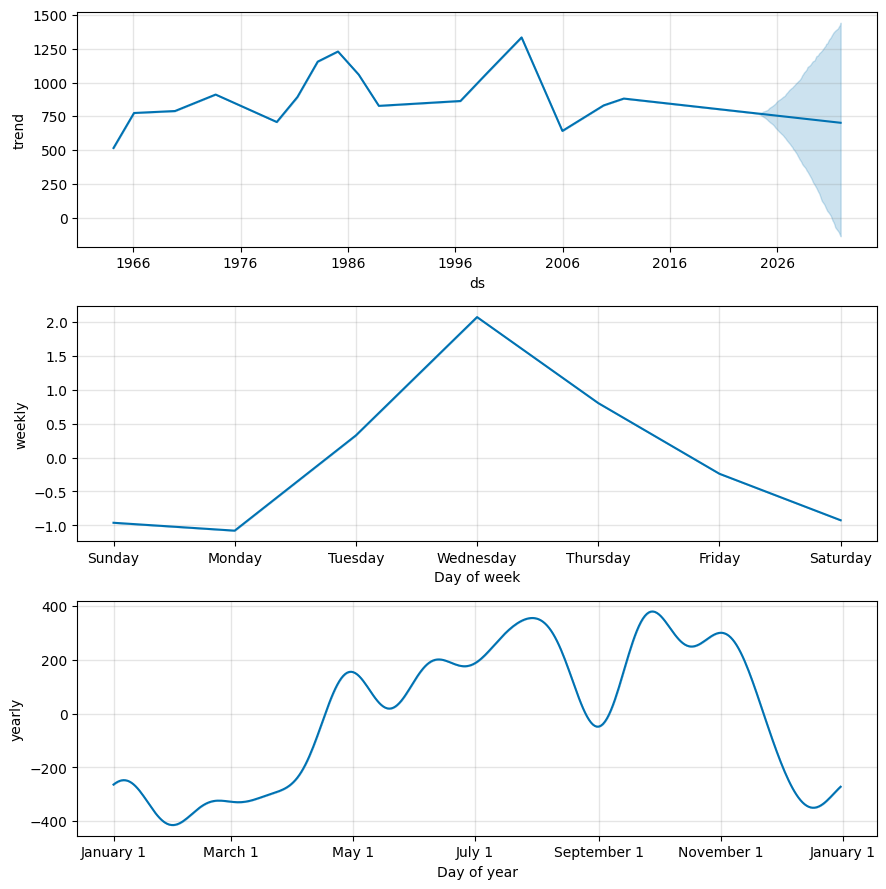

In [ ]:
#plot component wise forecast
fig2 = model.plot_components(forecast)

MODELOS DE PREVISÃO USADOS NA AULA
MEDIA
NAIVE
INGENUO
SAZONAL


atividade, plotar testes de residuo como Ljung box

Função de autocorrelação, no R acf(residuo)

medidas de acuracia

procurar funcoes de medida de acuracia

modelos de box jensing consideram distribuição normal

a partitr da proxima aula, vamos ver modelos:
modelos de regressão linear



ARIMA
ARMA

In [ ]:
#fit ARMA model to dataset
res = sm.tsa.ARIMA(data["SUNACTIVITY"], (1,1)).fit(disp=-1)

#perform Ljung-Box test on residuals with lag=5
sm.stats.acorr_ljungbox(res.resid, lags=[5], return_df=True)

#perform Ljung-Box test on residuals with lag=20
sm.stats.acorr_ljungbox(res.resid, lags=[20], return_df=True)

NameError: name 'sm' is not defined

In [ ]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.svm import SVR

mesh_size = .02
margin = 0

#df = px.data.iris()
timestamp_array = datetime_array.astype(np.int64) / 10**9

# Perform calculations with the timestamp_array and float_array
result = timestamp_array + float_array


X = df_flow[['Date', 'Flow']]
y = df_flow.iloc[:,1]

# Condition the model on sepal width and length, predict the petal width
model = SVR(C=1.)
model.fit(X, y)

# Create a mesh grid on which we will run our model
x_min, x_max = X.sepal_width.min() - margin, X.sepal_width.max() + margin
y_min, y_max = X.sepal_length.min() - margin, X.sepal_length.max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

# Run model
pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
pred = pred.reshape(xx.shape)

# Generate the plot
fig = px.scatter_3d(df, x='sepal_width', y='sepal_length', z='petal_width')
fig.update_traces(marker=dict(size=5))
fig.add_traces(go.Surface(x=xrange, y=yrange, z=pred, name='pred_surface'))
fig.show()

NameError: name 'datetime_array' is not defined